In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [14]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 10,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [11]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

## MNAR LR 1:2

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_right@0.7', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 19:00:28.136 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:00:28.137 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 19:01:21.317 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:01:21.318 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 19:02:13.974 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:02:13.975 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 19:03:02.196 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 19:03:02.197 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

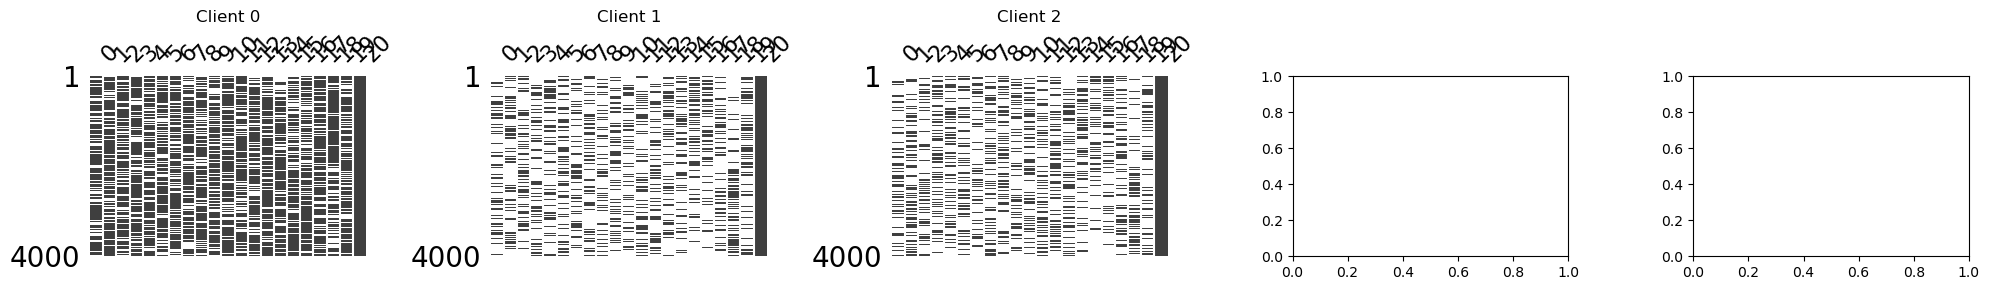

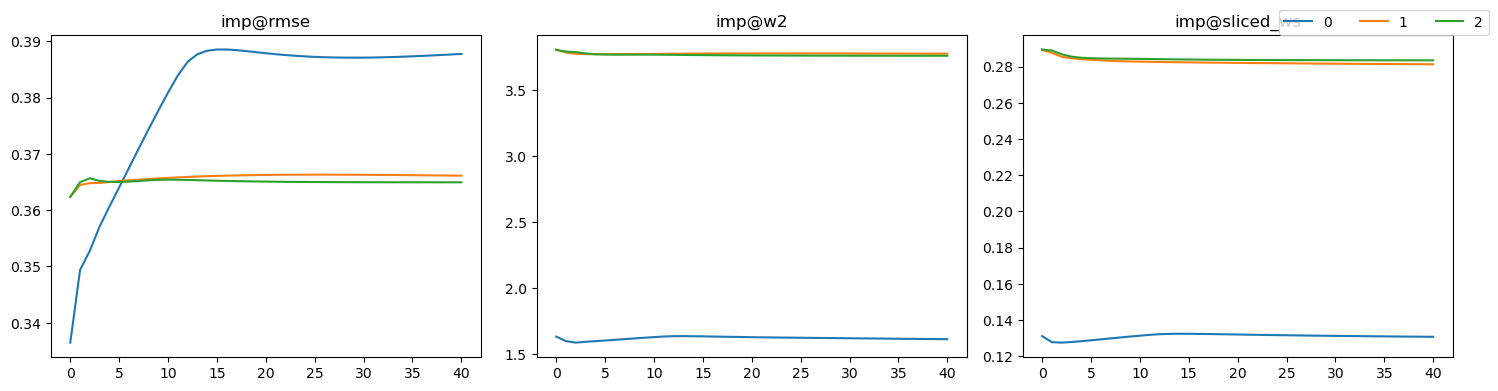

{'imp@rmse': 0.3728897220581385, 'imp@ws': 3.0477406125091537, 'imp@sliced_ws': 0.23182289556398197}


In [5]:
name = 'mnar_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [6]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-22 19:05:06.862 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6059, test_f1: 0.6011, val_loss: 0.7860, val_accu: 0.5283, val_f1: 0.5209
2023-07-22 19:06:16.718 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6136, test_f1: 0.6103, val_loss: 0.8119, val_accu: 0.5225, val_f1: 0.5133
2023-07-22 19:07:22.281 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6091, test_f1: 0.6062, val_loss: 0.8470, val_accu: 0.5196, val_f1: 0.5098
2023-07-22 19:08:29.724 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5996, test_f1: 0.5971, val_loss: 0.8976, val_accu: 0.5154, val_f1: 0.5048
2023-07-22 19:09:45.464 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5940, test_f1: 0.591

0.6582209754773324


In [7]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 19:15:41.283 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5132, train_loss: 0.6934 val_accu: 0.5075 val_f1: 0.3581
2023-07-22 19:16:07.274 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.6128, train_loss: 0.6290 val_accu: 0.6212 val_f1: 0.6207
2023-07-22 19:16:34.371 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6138, train_loss: 0.6137 val_accu: 0.6475 val_f1: 0.6434
2023-07-22 19:16:59.721 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6088, train_loss: 0.6018 val_accu: 0.6479 val_f1: 0.6385
2023-07-22 19:17:25.224 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6005, train_loss: 0.5922 val_accu: 0.6417 val_f1: 0.6276


0.6460048864356167


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-27 11:20:56.665 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:20:56.666 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:21:41.673 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:21:41.674 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:21:47.067 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 53.42301409994252


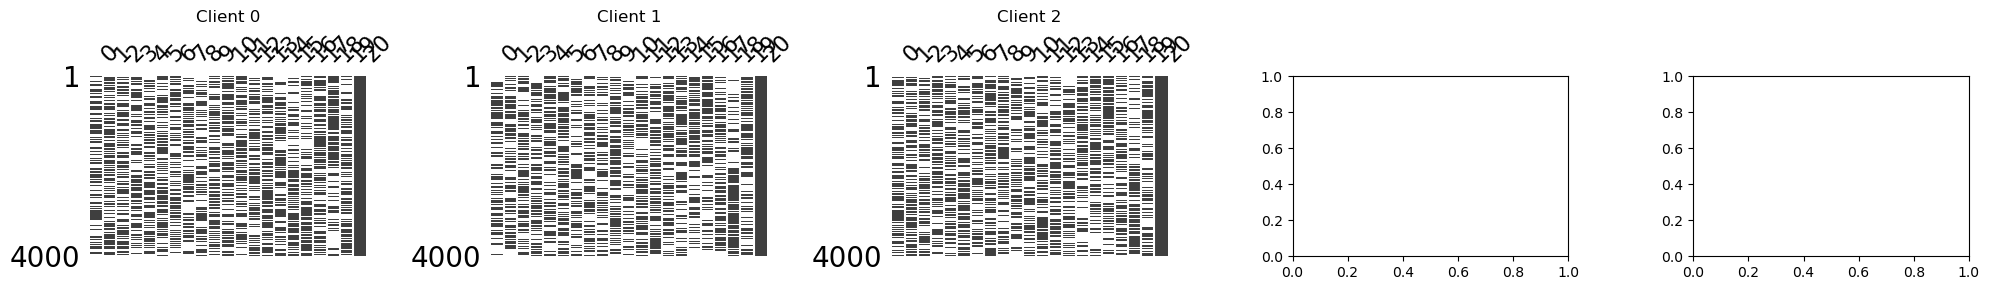

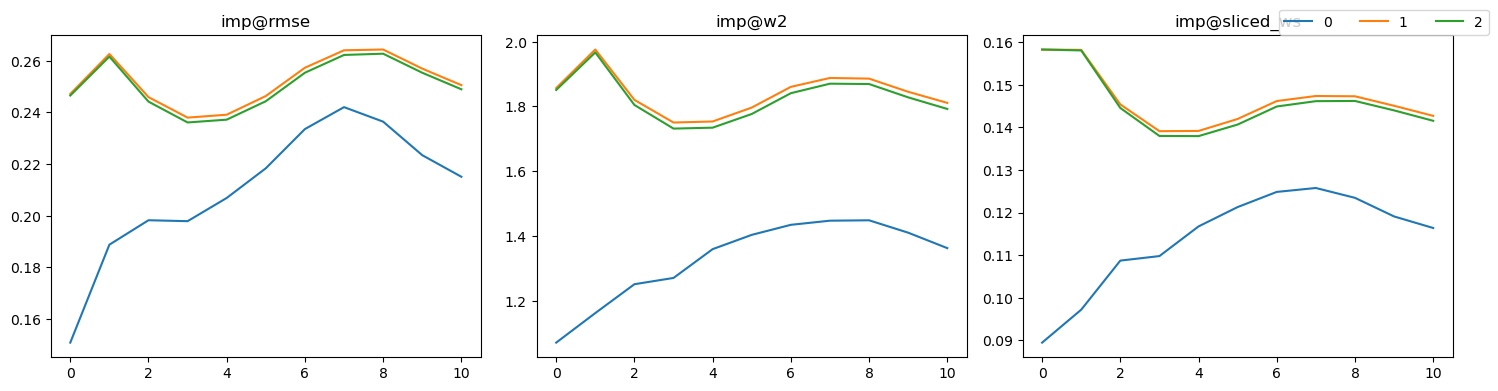

{'imp@rmse': 0.2485729917922803, 'imp@ws': 1.7060544693341266, 'imp@sliced_ws': 0.13739370498100956}


In [15]:
name = 'mnar_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [10]:
pred_ret = NN_evaluation(rets['mnar_lr12_savg'], type='fedavg', n_rounds=500, server_config_tmpl=server_config_tmpl)

2023-07-22 21:40:52.157 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7609, test_f1: 0.7556, val_loss: 0.5968, val_accu: 0.6758, val_f1: 0.6705
2023-07-22 21:42:02.599 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7779, test_f1: 0.7742, val_loss: 0.5915, val_accu: 0.6900, val_f1: 0.6874
2023-07-22 21:43:12.869 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7650, test_f1: 0.7604, val_loss: 0.5830, val_accu: 0.6967, val_f1: 0.6949
2023-07-22 21:44:19.890 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7746, test_f1: 0.7714, val_loss: 0.5799, val_accu: 0.6992, val_f1: 0.6985
2023-07-22 21:45:26.514 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7950, test_f1: 0.793

0.7953126413899194


In [11]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 21:51:01.021 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5102, train_loss: 0.6934 val_accu: 0.5133 val_f1: 0.4508
2023-07-22 21:51:25.078 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7302, train_loss: 0.5791 val_accu: 0.6954 val_f1: 0.6937
2023-07-22 21:51:50.111 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7224, train_loss: 0.5607 val_accu: 0.7204 val_f1: 0.7204
2023-07-22 21:52:15.398 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7150, train_loss: 0.5484 val_accu: 0.7238 val_f1: 0.7215
2023-07-22 21:52:41.019 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7070, train_loss: 0.5412 val_accu: 0.7317 val_f1: 0.7317


0.7842729164781468


### Our

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(11051, 21)


2023-07-27 11:22:03.548 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:22:03.549 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:22:50.810 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:22:50.810 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:22:56.050 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 55.45783009985462


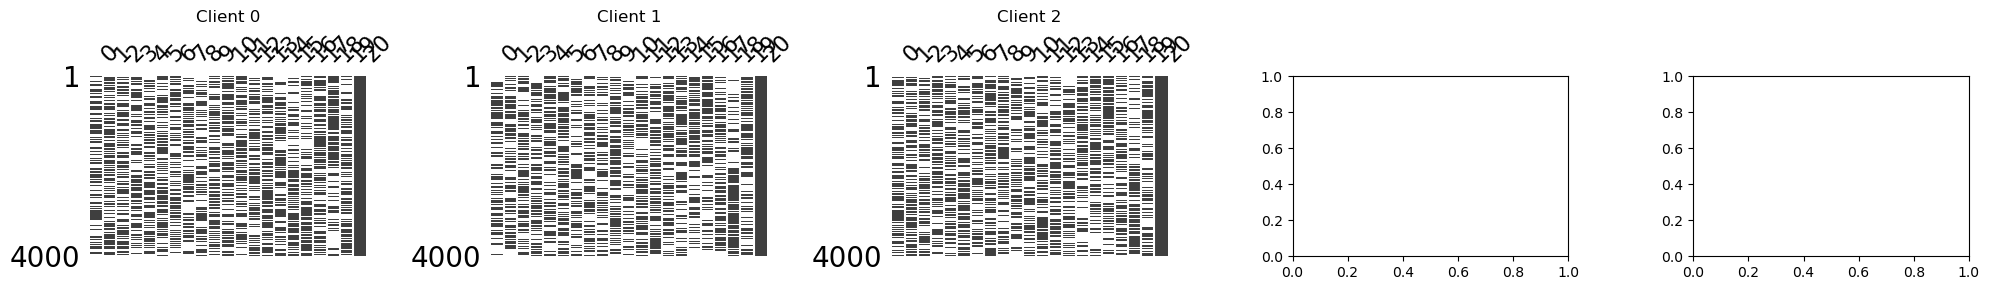

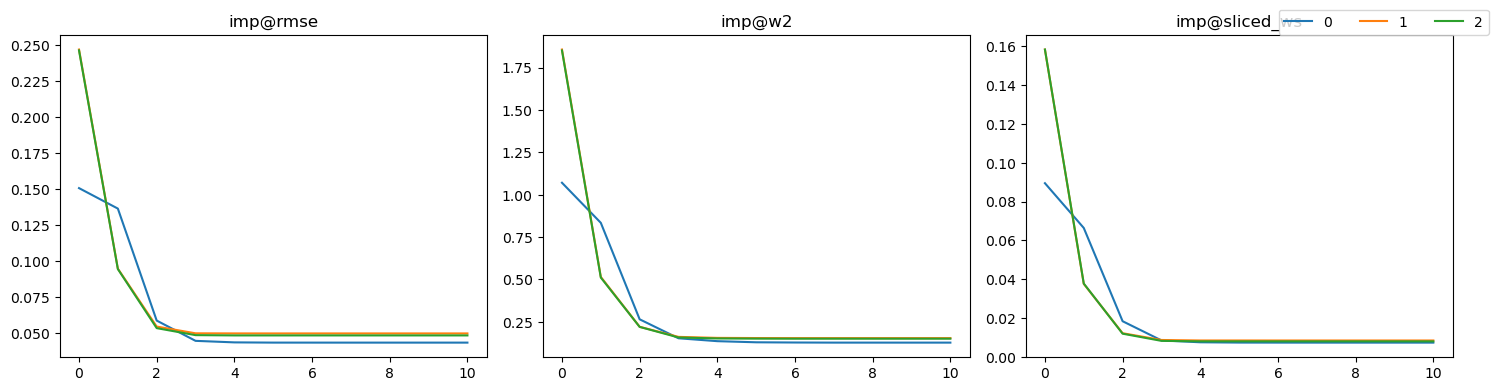

{'imp@rmse': 0.047396130228588684, 'imp@ws': 0.1442178840208168, 'imp@sliced_ws': 0.007932984480522785}


In [16]:
name = 'mnar_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [13]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 21:57:39.004 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9019, test_f1: 0.9019, val_loss: 0.3980, val_accu: 0.8292, val_f1: 0.8292
2023-07-22 21:58:46.019 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9101, test_f1: 0.9101, val_loss: 0.3752, val_accu: 0.8367, val_f1: 0.8367
2023-07-22 21:59:51.817 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9190, test_f1: 0.9190, val_loss: 0.3624, val_accu: 0.8475, val_f1: 0.8475
2023-07-22 22:00:59.230 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9244, test_f1: 0.9243, val_loss: 0.3535, val_accu: 0.8496, val_f1: 0.8496
2023-07-22 22:02:07.880 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9254, test_f1: 0.925

0.935661931046964


In [14]:
pred_ret = NN_evaluation(
    rets['mnar_lr12_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 22:07:44.944 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5375, train_loss: 0.6920 val_accu: 0.5296 val_f1: 0.4540
2023-07-22 22:08:07.580 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8964, train_loss: 0.3950 val_accu: 0.8258 val_f1: 0.8258
2023-07-22 22:08:32.486 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8783, train_loss: 0.3773 val_accu: 0.8087 val_f1: 0.8048
2023-07-22 22:08:57.168 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9208, train_loss: 0.3581 val_accu: 0.8488 val_f1: 0.8487
2023-07-22 22:09:21.980 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9261, train_loss: 0.3469 val_accu: 0.8488 val_f1: 0.8487


0.9311374536241064


## MNAR LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 22:10:02.892 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:10:02.893 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 22:10:49.005 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:10:49.006 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 22:11:33.577 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:11:33.578 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 22:12:18.253 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:12:18.254 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

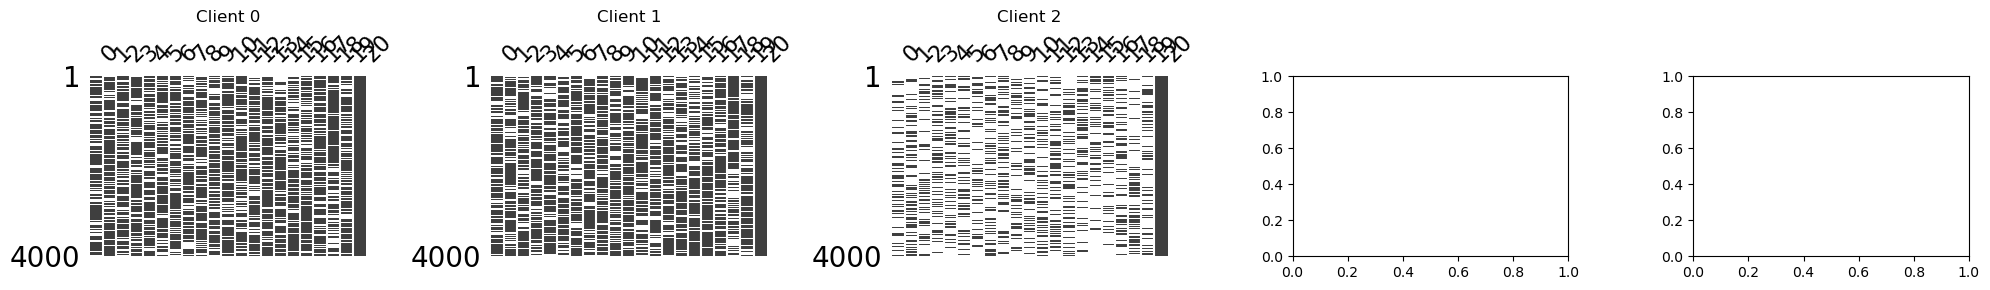

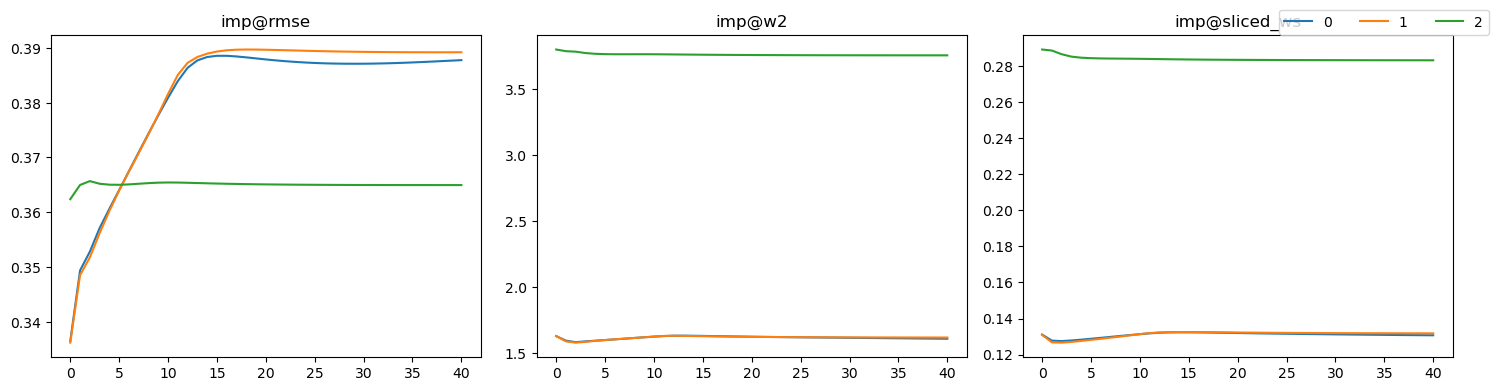

{'imp@rmse': 0.380564448487387, 'imp@ws': 2.3297517007856743, 'imp@sliced_ws': 0.18198347439309845}


In [15]:
name = 'mnar_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [16]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 22:14:17.088 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5806, test_f1: 0.5797, val_loss: 0.9367, val_accu: 0.5267, val_f1: 0.5171
2023-07-22 22:15:21.967 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.5722, test_f1: 0.5711, val_loss: 1.0223, val_accu: 0.5217, val_f1: 0.5109
2023-07-22 22:16:26.184 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.5741, test_f1: 0.5733, val_loss: 1.1055, val_accu: 0.5183, val_f1: 0.5062
2023-07-22 22:17:30.424 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5790, test_f1: 0.5785, val_loss: 1.2768, val_accu: 0.5133, val_f1: 0.5003
2023-07-22 22:18:36.328 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5736, test_f1: 0.573

0.6439236268211022


In [17]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 22:23:48.524 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5202, train_loss: 0.6932 val_accu: 0.5125 val_f1: 0.4076
2023-07-22 22:24:12.112 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.6545, train_loss: 0.5612 val_accu: 0.6954 val_f1: 0.6949
2023-07-22 22:24:36.425 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6607, train_loss: 0.5493 val_accu: 0.6813 val_f1: 0.6727
2023-07-22 22:25:00.285 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6310, train_loss: 0.5310 val_accu: 0.6958 val_f1: 0.6884
2023-07-22 22:25:24.695 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6251, train_loss: 0.5124 val_accu: 0.7192 val_f1: 0.7172


0.663921817030133


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 22:26:04.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:26:04.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 22:26:51.229 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:26:51.230 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 22:27:37.499 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:27:37.500 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 22:28:23.537 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:28:23.538 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

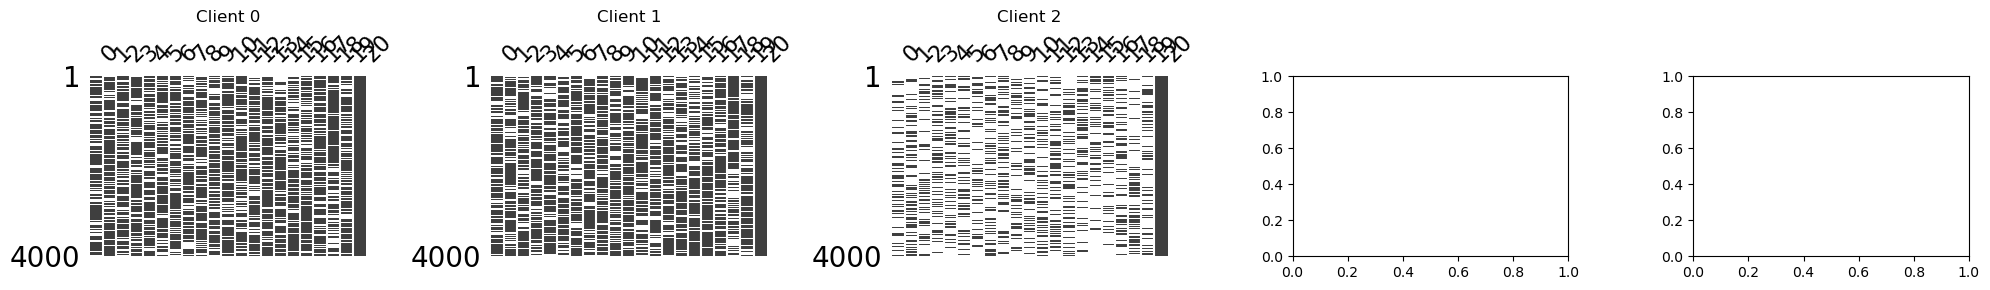

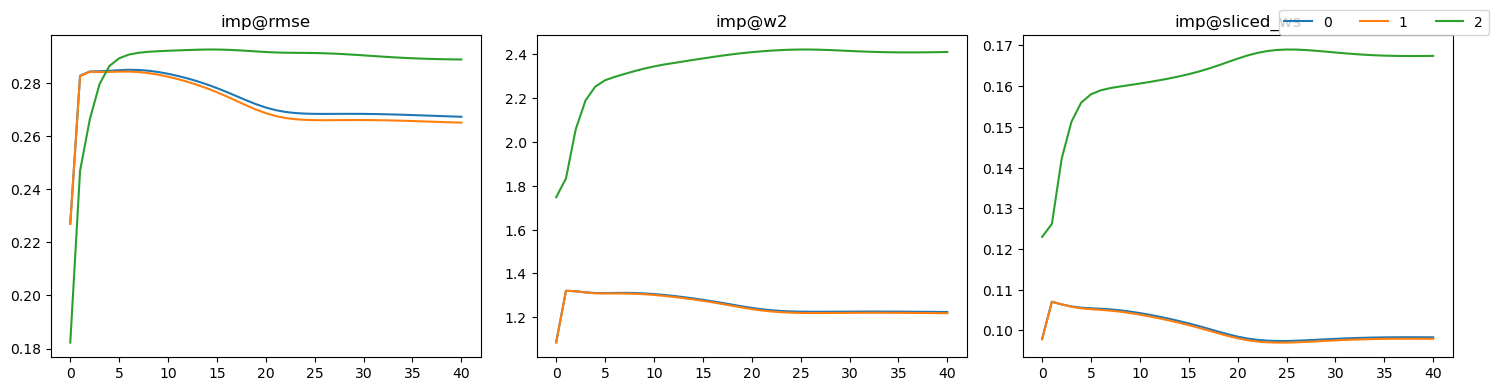

{'imp@rmse': 0.2740571056540299, 'imp@ws': 1.6178142023695041, 'imp@sliced_ws': 0.12123502105479694}


In [18]:
name = 'mnar_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [19]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_savg'], type='fedavg', n_rounds=500,server_config_tmpl = server_config_tmpl)

2023-07-22 22:30:19.713 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7345, test_f1: 0.7345, val_loss: 0.5760, val_accu: 0.7025, val_f1: 0.6990
2023-07-22 22:31:25.974 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6827, test_f1: 0.6827, val_loss: 0.5691, val_accu: 0.7096, val_f1: 0.7077
2023-07-22 22:32:32.592 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6666, test_f1: 0.6663, val_loss: 0.5684, val_accu: 0.7071, val_f1: 0.7065
2023-07-22 22:33:38.390 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6635, test_f1: 0.6623, val_loss: 0.5715, val_accu: 0.7104, val_f1: 0.7096
2023-07-22 22:34:42.909 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6611, test_f1: 0.659

0.7495249298705999


In [20]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 22:40:14.704 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5237, train_loss: 0.6931 val_accu: 0.5104 val_f1: 0.4284
2023-07-22 22:40:41.269 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7085, train_loss: 0.5414 val_accu: 0.7321 val_f1: 0.7319
2023-07-22 22:41:07.323 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6697, train_loss: 0.5253 val_accu: 0.7421 val_f1: 0.7410
2023-07-22 22:41:30.725 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6529, train_loss: 0.4984 val_accu: 0.7458 val_f1: 0.7436
2023-07-22 22:41:55.848 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6401, train_loss: 0.4831 val_accu: 0.7629 val_f1: 0.7627


0.7440050674147136


### Our Models

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left@0.3', 'mnar_quantile_left@0.3', 'mnar_quantile_right@0.7']
(11051, 21)


2023-07-22 22:42:35.592 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:42:35.593 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 22:43:21.799 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:43:21.800 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 22:44:07.412 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:44:07.413 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 22:44:53.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:44:53.932 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

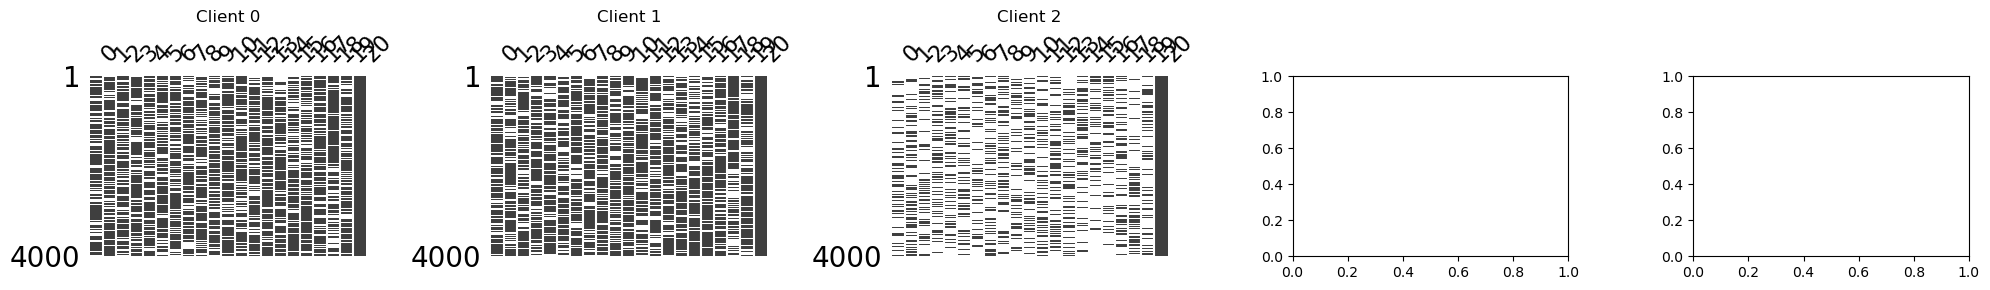

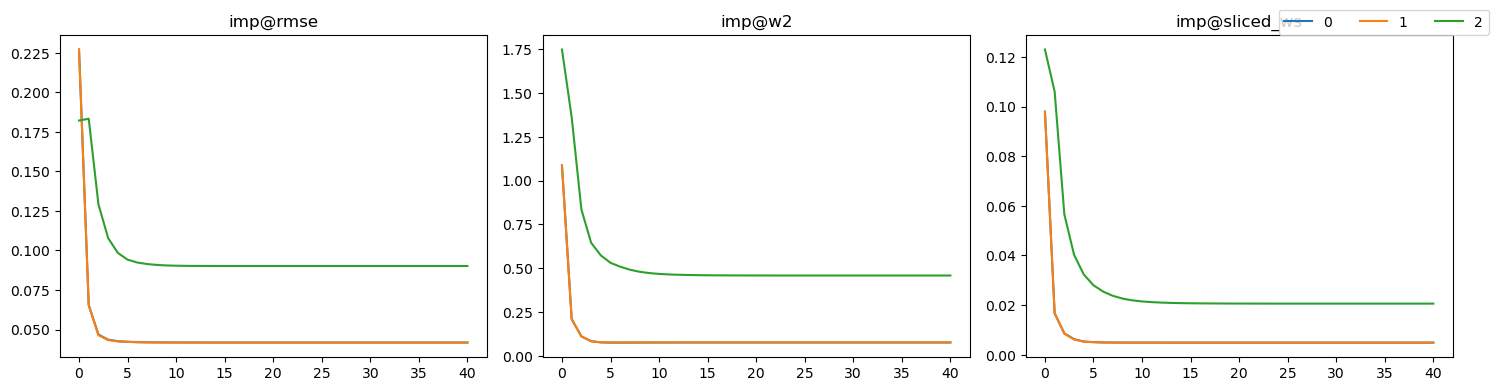

{'imp@rmse': 0.057891156839928334, 'imp@ws': 0.20333165504438283, 'imp@sliced_ws': 0.010081771987598496}


In [21]:
name = 'mnar_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [22]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 22:46:50.322 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9087, test_f1: 0.9086, val_loss: 0.3577, val_accu: 0.8562, val_f1: 0.8562
2023-07-22 22:47:55.487 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9301, test_f1: 0.9301, val_loss: 0.3264, val_accu: 0.8700, val_f1: 0.8700
2023-07-22 22:48:57.809 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9387, test_f1: 0.9387, val_loss: 0.3095, val_accu: 0.8783, val_f1: 0.8783
2023-07-22 22:50:02.665 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9435, test_f1: 0.9435, val_loss: 0.3008, val_accu: 0.8788, val_f1: 0.8787
2023-07-22 22:51:05.330 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9451, test_f1: 0.945

0.9476970409917654


In [23]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 22:56:15.383 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5511, train_loss: 0.6916 val_accu: 0.5337 val_f1: 0.4685
2023-07-22 22:56:38.617 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.9088, train_loss: 0.3490 val_accu: 0.8579 val_f1: 0.8576
2023-07-22 22:57:03.361 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8877, train_loss: 0.3302 val_accu: 0.8421 val_f1: 0.8400
2023-07-22 22:57:26.648 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9305, train_loss: 0.3104 val_accu: 0.8733 val_f1: 0.8733
2023-07-22 22:57:51.049 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9335, train_loss: 0.2960 val_accu: 0.8750 val_f1: 0.8749


0.9389195547914216


## MARY LR 1:2

### Local 

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 22:58:31.483 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:58:31.484 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 22:59:16.845 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 22:59:16.846 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:00:01.890 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:00:01.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:00:47.243 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:00:47.243 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

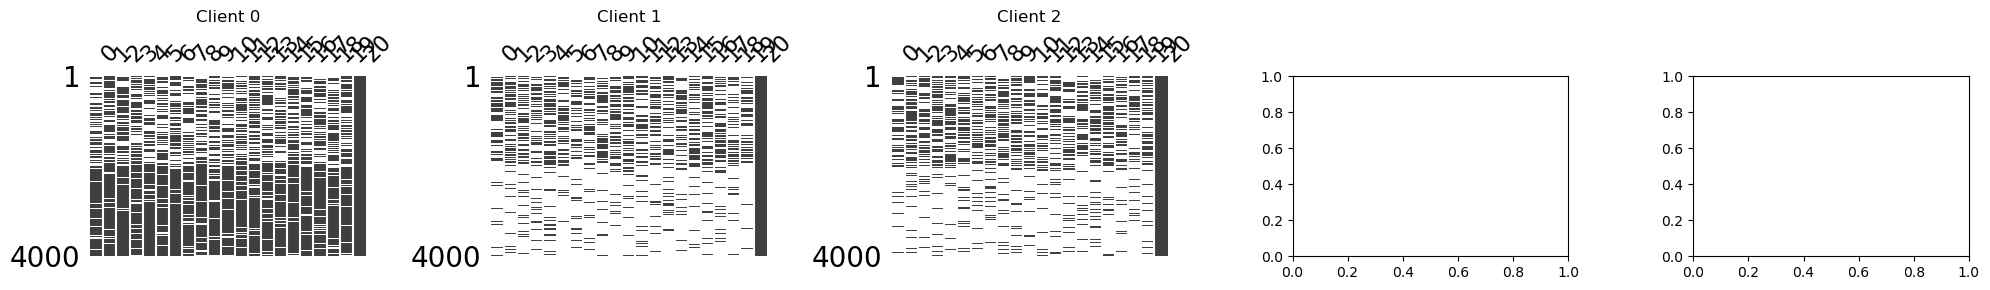

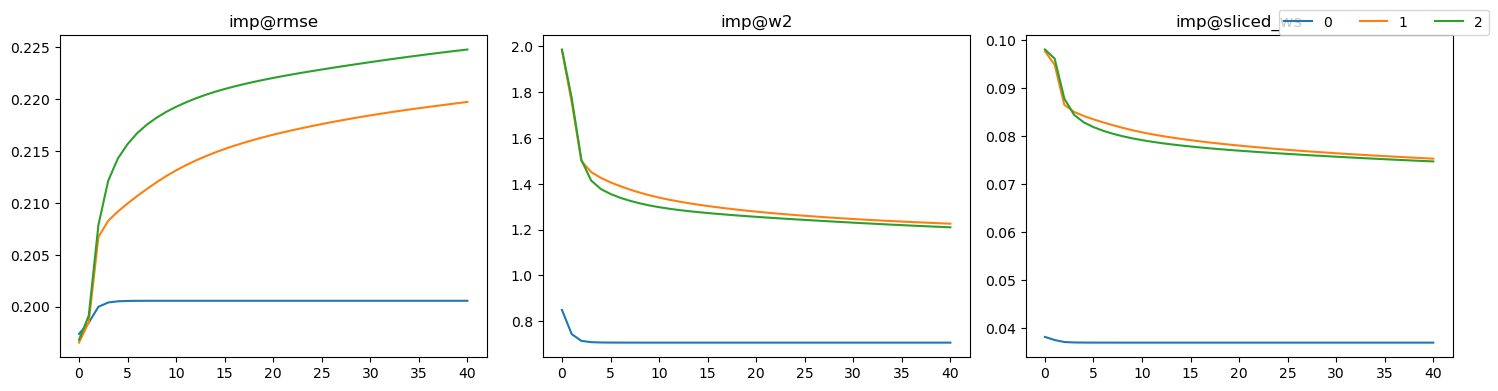

{'imp@rmse': 0.21483419636511594, 'imp@ws': 1.04982205447191, 'imp@sliced_ws': 0.06235744940589962}


In [24]:
name = 'mary_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [25]:
pred_ret = NN_evaluation(
    rets['mary_lr12_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:02:42.800 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7438, test_f1: 0.7388, val_loss: 0.7963, val_accu: 0.6212, val_f1: 0.5743
2023-07-22 23:03:45.959 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7685, test_f1: 0.7669, val_loss: 0.7857, val_accu: 0.6329, val_f1: 0.5935
2023-07-22 23:04:48.004 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7809, test_f1: 0.7808, val_loss: 0.7449, val_accu: 0.6512, val_f1: 0.6215
2023-07-22 23:05:55.534 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7934, test_f1: 0.7934, val_loss: 0.7278, val_accu: 0.6562, val_f1: 0.6291
2023-07-22 23:07:03.181 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7995, test_f1: 0.799

0.8006515247488915


In [26]:
pred_ret = NN_evaluation(
    rets['mary_lr12_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:12:18.972 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5008, train_loss: 0.6902 val_accu: 0.6088 val_f1: 0.5494
2023-07-22 23:12:43.470 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8169, train_loss: 0.4297 val_accu: 0.7887 val_f1: 0.7886
2023-07-22 23:13:07.503 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8175, train_loss: 0.4066 val_accu: 0.8021 val_f1: 0.8017
2023-07-22 23:13:31.248 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8016, train_loss: 0.3886 val_accu: 0.8071 val_f1: 0.8070
2023-07-22 23:13:55.133 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8054, train_loss: 0.3836 val_accu: 0.8108 val_f1: 0.8108


0.8486109854311827


### Simple Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 23:14:34.806 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:14:34.807 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 23:15:21.950 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:15:21.951 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:16:09.063 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:16:09.065 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:16:55.561 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:16:55.561 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

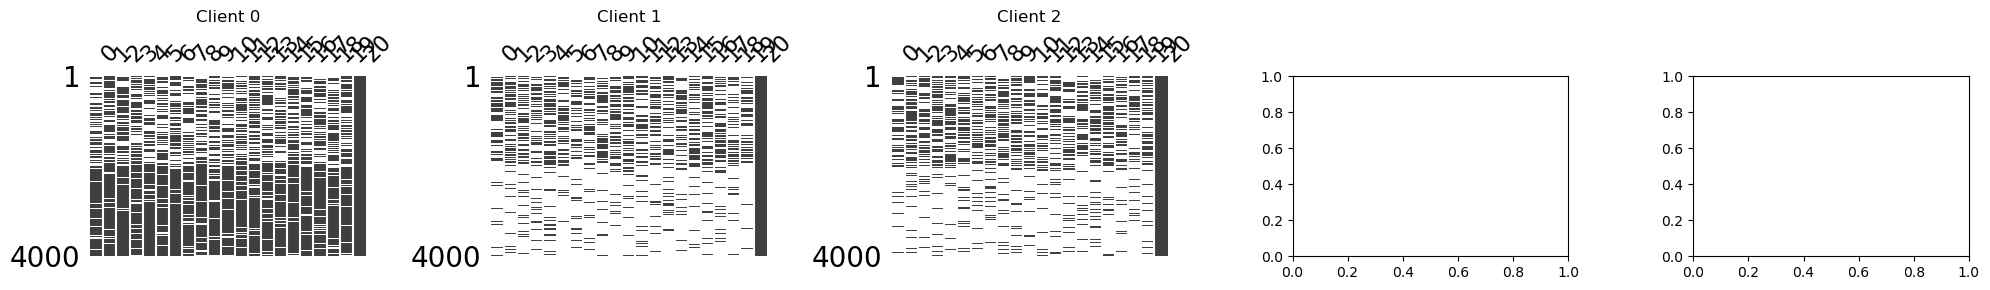

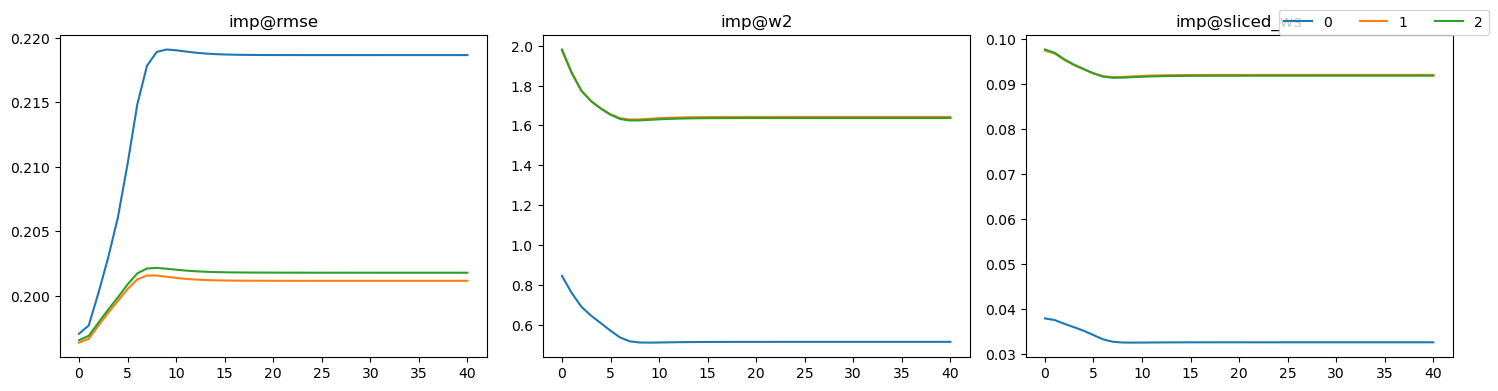

{'imp@rmse': 0.20721564465922732, 'imp@ws': 1.2645056524050304, 'imp@sliced_ws': 0.07217297816631461}


In [27]:
name = 'mary_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [28]:
pred_ret = NN_evaluation(
    rets['mary_lr12_savg'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:18:51.603 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7534, test_f1: 0.7532, val_loss: 0.6835, val_accu: 0.6421, val_f1: 0.6150
2023-07-22 23:19:55.091 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7654, test_f1: 0.7653, val_loss: 0.6663, val_accu: 0.6621, val_f1: 0.6417
2023-07-22 23:20:57.308 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7648, test_f1: 0.7648, val_loss: 0.6527, val_accu: 0.6700, val_f1: 0.6536
2023-07-22 23:21:58.858 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7712, test_f1: 0.7712, val_loss: 0.6485, val_accu: 0.6742, val_f1: 0.6589
2023-07-22 23:23:02.266 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7638, test_f1: 0.763

0.7733236811148312


In [42]:
pred_ret = NN_evaluation(
    rets['mary_lr12_savg'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:31:41.623 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5000, train_loss: 0.6917 val_accu: 0.4992 val_f1: 0.3381
2023-07-23 00:32:05.389 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8202, train_loss: 0.4140 val_accu: 0.8200 val_f1: 0.8200
2023-07-23 00:32:28.806 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7826, train_loss: 0.3924 val_accu: 0.7746 val_f1: 0.7684
2023-07-23 00:32:52.618 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8140, train_loss: 0.3705 val_accu: 0.8308 val_f1: 0.8304
2023-07-23 00:33:16.051 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8204, train_loss: 0.3605 val_accu: 0.8479 val_f1: 0.8479


0.8468011944620396


### Our Method

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 23:30:41.195 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:30:41.196 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 23:31:27.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:31:27.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:32:13.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:32:13.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:32:57.501 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:32:57.501 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

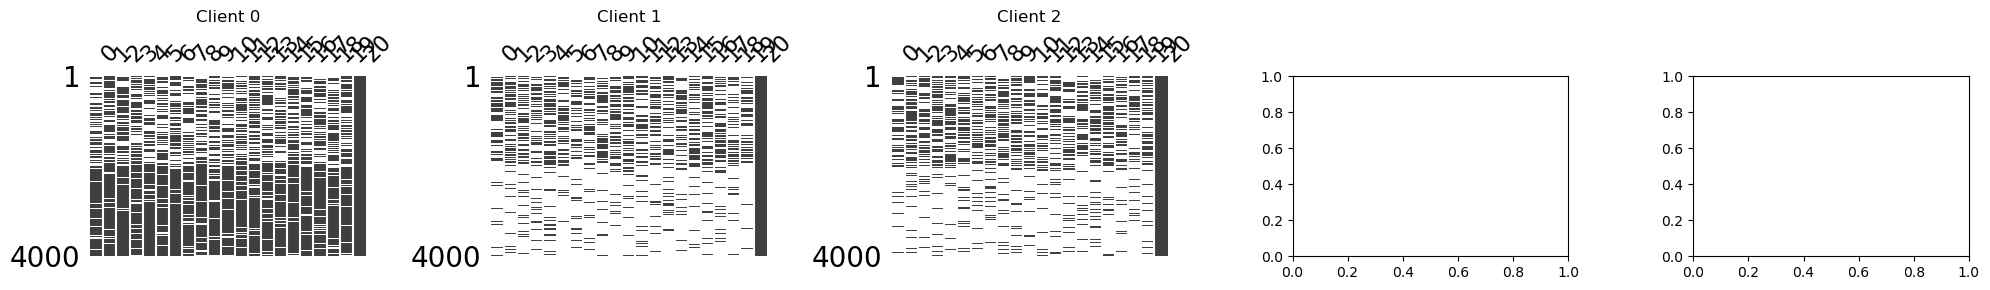

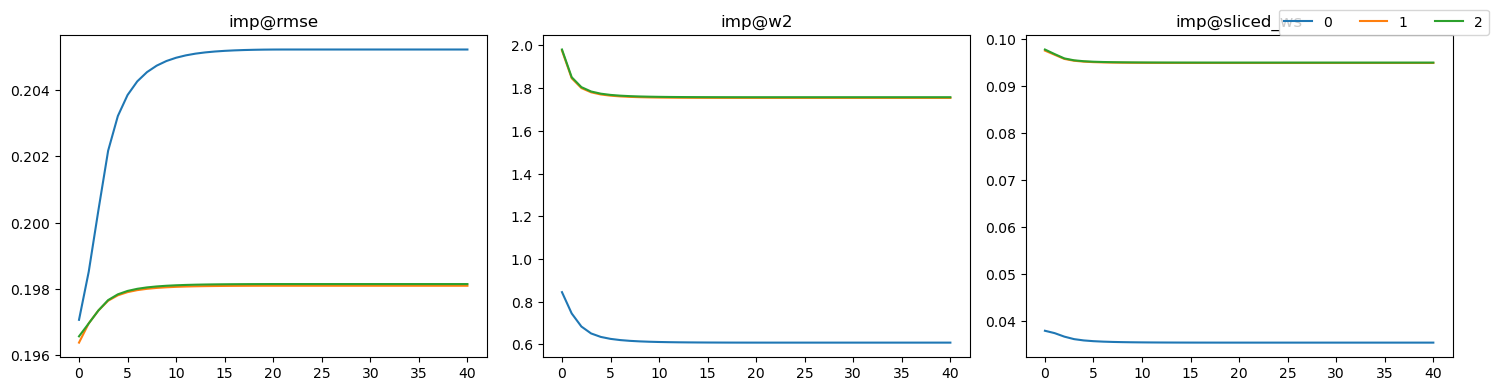

{'imp@rmse': 0.20049003694702353, 'imp@ws': 1.3734046821757693, 'imp@sliced_ws': 0.07504387302058735}


In [30]:
name = 'mary_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [31]:
pred_ret = NN_evaluation(
    rets['mary_lr12_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:34:54.138 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7712, test_f1: 0.7667, val_loss: 0.5621, val_accu: 0.7371, val_f1: 0.7335
2023-07-22 23:35:58.984 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7627, test_f1: 0.7560, val_loss: 0.5652, val_accu: 0.7342, val_f1: 0.7313
2023-07-22 23:37:04.118 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7484, test_f1: 0.7390, val_loss: 0.5565, val_accu: 0.7467, val_f1: 0.7450
2023-07-22 23:38:09.053 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7353, test_f1: 0.7236, val_loss: 0.5404, val_accu: 0.7504, val_f1: 0.7496
2023-07-22 23:39:17.577 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7267, test_f1: 0.712

0.7963080264229482


In [32]:
pred_ret = NN_evaluation(
    rets['mary_lr12_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:43:54.368 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5035, train_loss: 0.6921 val_accu: 0.5112 val_f1: 0.3717
2023-07-22 23:44:17.116 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8696, train_loss: 0.3773 val_accu: 0.8417 val_f1: 0.8417
2023-07-22 23:44:42.146 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7855, train_loss: 0.3525 val_accu: 0.8208 val_f1: 0.8186
2023-07-22 23:45:07.204 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8344, train_loss: 0.3382 val_accu: 0.8492 val_f1: 0.8491
2023-07-22 23:45:32.293 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8435, train_loss: 0.3284 val_accu: 0.8550 val_f1: 0.8550


0.8803728169396434


## MARY LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-22 23:46:12.934 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:46:12.935 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-22 23:46:57.988 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:46:57.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-22 23:47:41.969 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:47:41.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-22 23:48:25.881 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-22 23:48:25.882 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

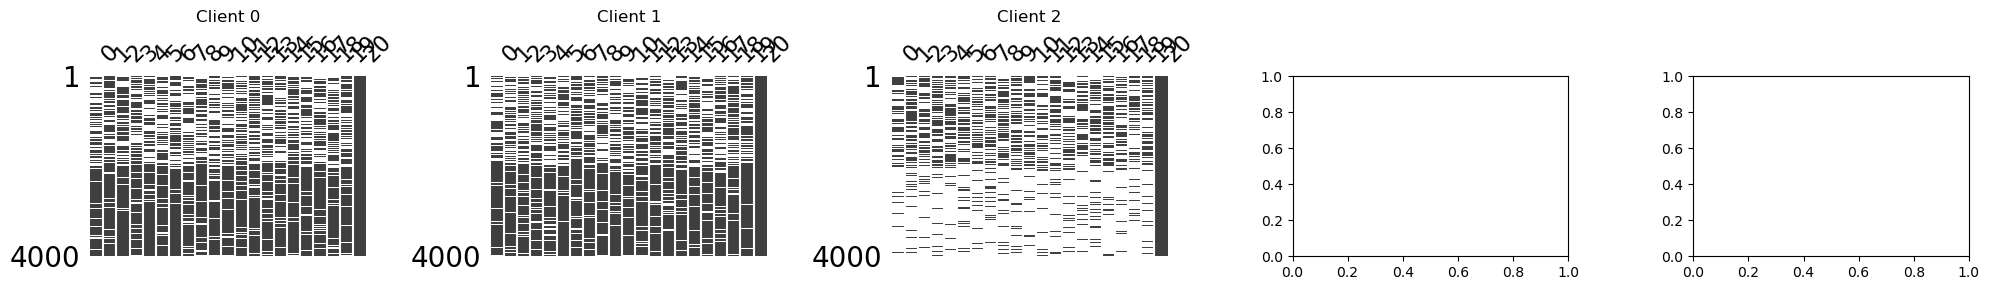

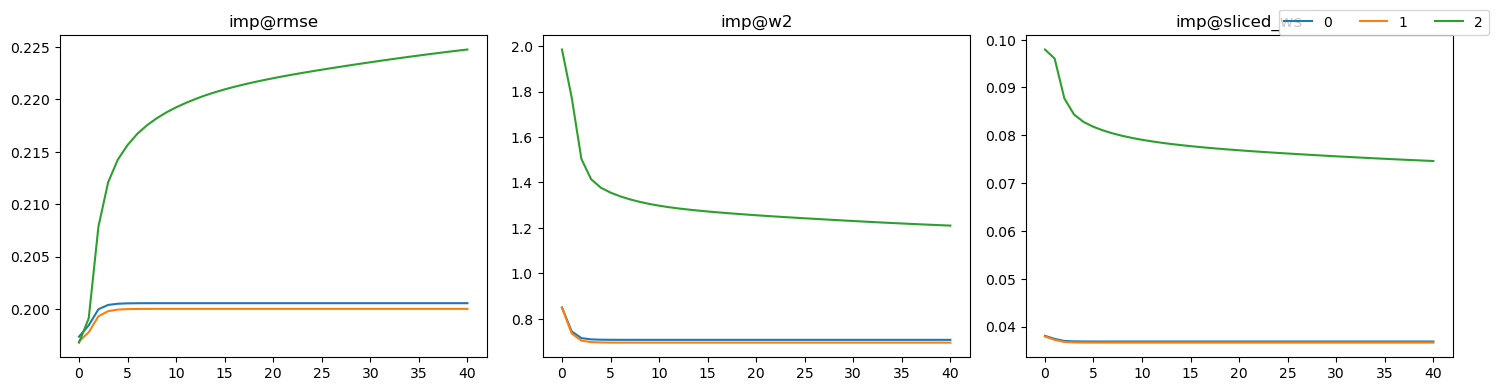

{'imp@rmse': 0.20835748576934607, 'imp@ws': 0.8716385543890449, 'imp@sliced_ws': 0.04943717574655493}


In [33]:
name = 'mary_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [34]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:50:22.903 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8217, test_f1: 0.8189, val_loss: 0.8710, val_accu: 0.7121, val_f1: 0.7029
2023-07-22 23:51:31.205 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7655, test_f1: 0.7550, val_loss: 0.8615, val_accu: 0.7221, val_f1: 0.7156
2023-07-22 23:52:39.290 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7524, test_f1: 0.7399, val_loss: 0.9160, val_accu: 0.7242, val_f1: 0.7188
2023-07-22 23:53:44.126 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7102, test_f1: 0.6864, val_loss: 0.9177, val_accu: 0.7200, val_f1: 0.7169
2023-07-22 23:54:49.490 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6896, test_f1: 0.658

0.8240883177992941


In [35]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-22 23:59:12.078 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5056, train_loss: 0.6930 val_accu: 0.5033 val_f1: 0.3901
2023-07-22 23:59:35.027 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7268, train_loss: 0.4917 val_accu: 0.7675 val_f1: 0.7675
2023-07-22 23:59:58.385 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6513, train_loss: 0.4607 val_accu: 0.7750 val_f1: 0.7738
2023-07-23 00:00:21.690 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6177, train_loss: 0.4361 val_accu: 0.7646 val_f1: 0.7613
2023-07-23 00:00:45.496 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6478, train_loss: 0.4113 val_accu: 0.8100 val_f1: 0.8099


0.8056284499140349


### Simpel Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-23 00:01:24.042 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:01:24.042 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 00:02:09.251 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:02:09.252 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 00:02:53.558 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:02:53.559 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 00:03:37.209 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:03:37.210 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

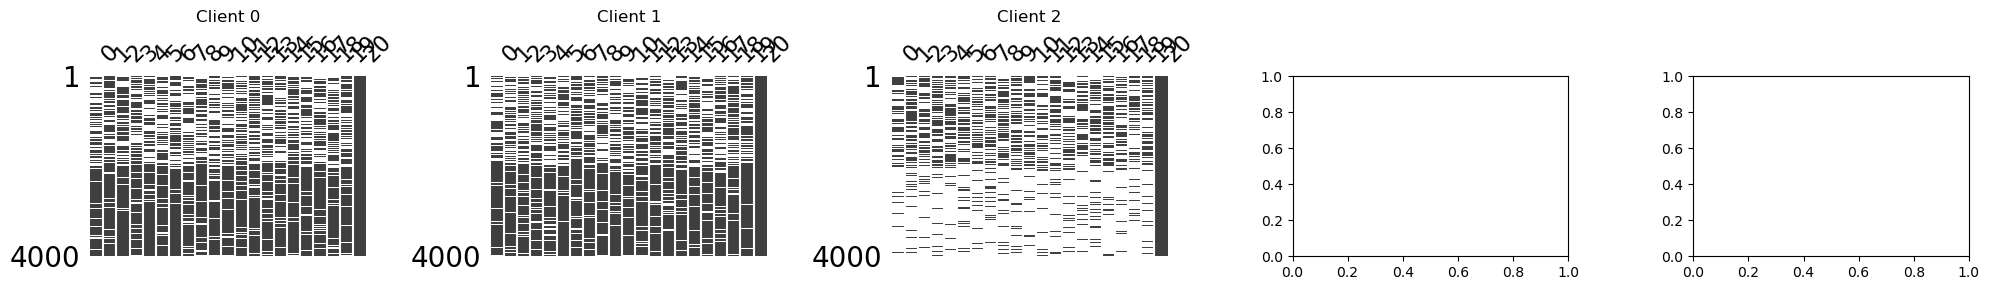

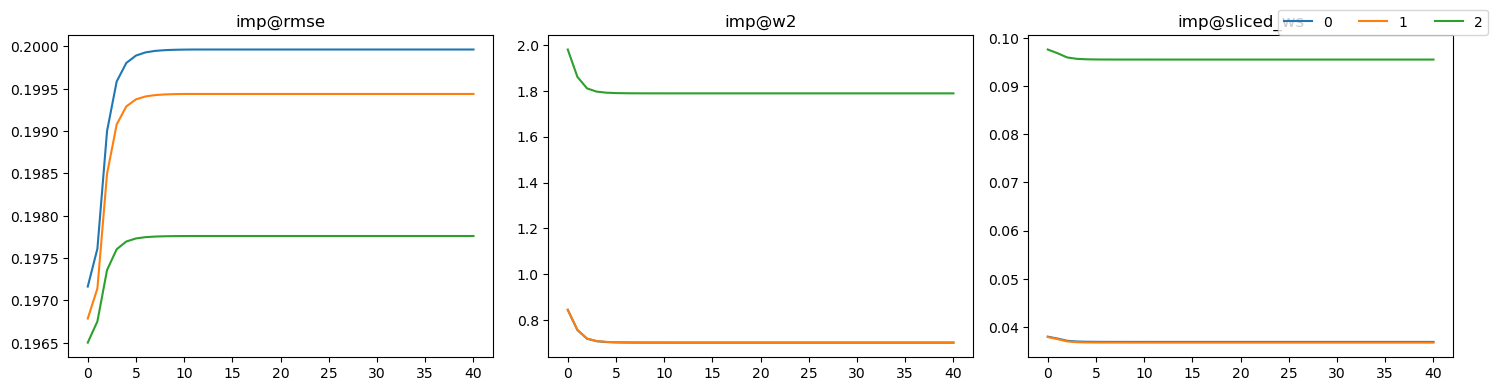

{'imp@rmse': 0.19905443089554506, 'imp@ws': 1.065175062213047, 'imp@sliced_ws': 0.05636542173626157}


In [36]:
name = 'mary_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [37]:
pred_ret = NN_evaluation(
    rets['mary_lr21_savg'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:05:31.093 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8429, test_f1: 0.8427, val_loss: 0.8051, val_accu: 0.7117, val_f1: 0.6956
2023-07-23 00:06:35.263 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8576, test_f1: 0.8564, val_loss: 0.8391, val_accu: 0.7254, val_f1: 0.7117
2023-07-23 00:07:39.368 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8280, test_f1: 0.8251, val_loss: 0.8700, val_accu: 0.7292, val_f1: 0.7160
2023-07-23 00:08:43.393 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8235, test_f1: 0.8203, val_loss: 0.9095, val_accu: 0.7292, val_f1: 0.7153
2023-07-23 00:09:48.121 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8112, test_f1: 0.806

0.8624558863451272


In [38]:
pred_ret = NN_evaluation(
    rets['mary_lr21_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:14:21.039 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5056, train_loss: 0.6930 val_accu: 0.5033 val_f1: 0.3901
2023-07-23 00:14:45.340 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7268, train_loss: 0.4917 val_accu: 0.7675 val_f1: 0.7675
2023-07-23 00:15:10.084 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6513, train_loss: 0.4607 val_accu: 0.7750 val_f1: 0.7738
2023-07-23 00:15:34.814 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6177, train_loss: 0.4361 val_accu: 0.7646 val_f1: 0.7613
2023-07-23 00:15:59.637 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6478, train_loss: 0.4113 val_accu: 0.8100 val_f1: 0.8099


0.8056284499140349


### Ours

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left@0.3', 'mary_sigmoid_left@0.3', 'mary_sigmoid_right@0.7']
(11051, 21)


2023-07-23 00:16:39.806 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:16:39.807 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 1
2023-07-23 00:17:27.521 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:17:27.521 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 10
2023-07-23 00:18:13.732 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:18:13.733 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 20
2023-07-23 00:19:01.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:147 - ==================================================
2023-07-23 00:19:01.166 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - Imputation Round 

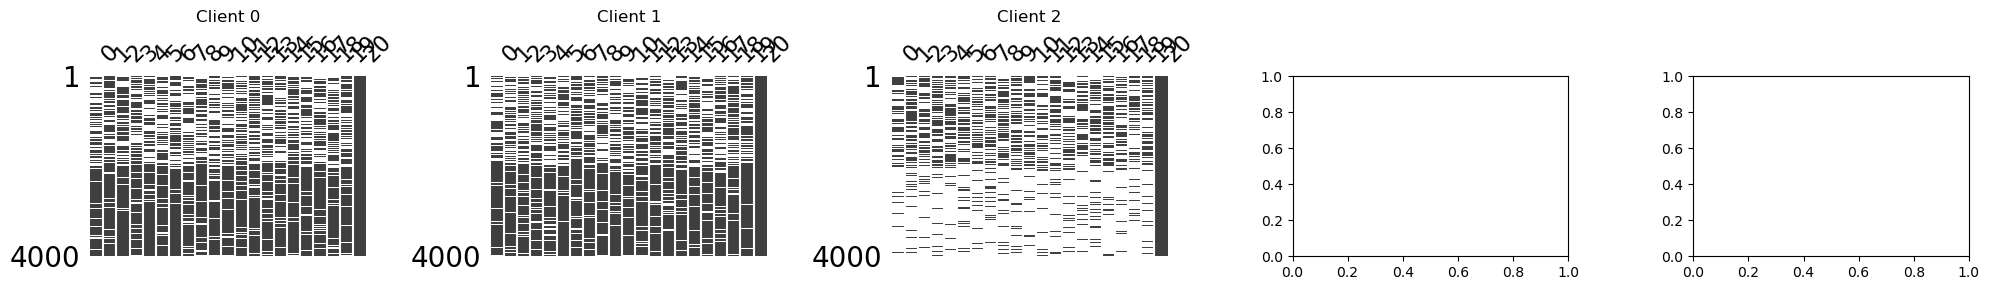

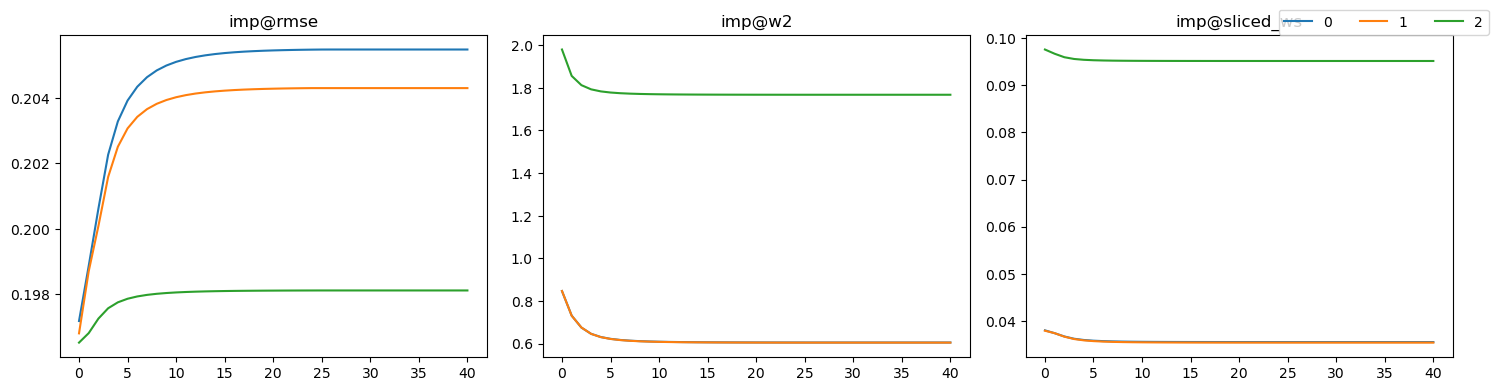

{'imp@rmse': 0.20263661509755337, 'imp@ws': 0.9918359308182967, 'imp@sliced_ws': 0.05532240804356454}


In [39]:
name = 'mary_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [40]:
pred_ret = NN_evaluation(
    rets['mary_lr21_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:20:56.858 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8242, test_f1: 0.8230, val_loss: 0.6226, val_accu: 0.7308, val_f1: 0.7170
2023-07-23 00:22:01.419 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8242, test_f1: 0.8221, val_loss: 0.6411, val_accu: 0.7312, val_f1: 0.7163
2023-07-23 00:23:06.113 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8038, test_f1: 0.7999, val_loss: 0.6507, val_accu: 0.7350, val_f1: 0.7206
2023-07-23 00:24:10.816 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7952, test_f1: 0.7899, val_loss: 0.6787, val_accu: 0.7375, val_f1: 0.7233
2023-07-23 00:25:15.919 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7884, test_f1: 0.782

0.8355804904533526


In [41]:
pred_ret = NN_evaluation(
    rets['mary_lr21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl)

2023-07-23 00:29:40.321 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5327, train_loss: 0.6923 val_accu: 0.5312 val_f1: 0.4507
2023-07-23 00:30:05.438 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7684, train_loss: 0.3718 val_accu: 0.8512 val_f1: 0.8508
2023-07-23 00:30:28.947 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6940, train_loss: 0.3343 val_accu: 0.8333 val_f1: 0.8306
2023-07-23 00:30:52.657 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7123, train_loss: 0.3143 val_accu: 0.8746 val_f1: 0.8744
2023-07-23 00:31:16.354 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7240, train_loss: 0.2972 val_accu: 0.8812 val_f1: 0.8812


0.8468011944620396
